In [1]:
import scipy
from scipy.special import j0
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
n_count = 32
act = 'tanh'
model = keras.Sequential(
    [
        layers.Input(shape=(1,)),
        layers.Dense(n_count, activation=act),
        layers.Dense(n_count, activation=act),
        layers.Dense(n_count, activation=act),
        layers.Dense(1),
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,209 (8.63 KB)

 Trainable params: 2,209 (8.63 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
x_bound = tf.Variable([[0.0]], dtype=tf.float32, trainable=True)
x_phys = tf.Variable(np.reshape(np.linspace(0.1, 20., 100), (100, 1)), dtype=tf.float32, trainable=True)
x_inn = tf.Variable(np.reshape(np.linspace(0.1, 7.5, 5), (5, 1)), dtype=tf.float32, trainable=True)
y_inn = j0(x_inn)

In [4]:
epochs = 70_000
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

for i in range(epochs + 1):
    with tf.GradientTape(persistent=True) as tape:
        with tf.GradientTape() as tape1:
            y_0 = model(x_bound, training=True)
            dy_0 = tape1.gradient(y_0, x_bound)
            bc_1 = tf.square(dy_0)

        with tf.GradientTape() as tape2:
            y_0 = model(x_phys, training=True)
            dy_0 = tape2.gradient(y_0, x_phys)
            d2y_0 = tape.gradient(dy_0, x_phys)
            phys_loss = tf.reduce_mean(tf.square(x_phys ** 2 * d2y_0 + x_phys * dy_0 + x_phys ** 2 * y_0), axis=0)

        y_0 = model(x_bound)
        bound_loss = tf.square(y_0 - 1.)
        
        y = model(x_inn)
        inn_loss = tf.reduce_mean(tf.square(y - y_inn), axis=0)
        
        loss = bound_loss + bc_1 + 1e-3 * phys_loss + inn_loss
        
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
        
    del tape
    
    if i % 5000 == 0:
        print(f"Epoch {i}, loss: {loss}")
    if loss <= 1e-5:
        break
            

Epoch 0, loss: [[4.744773]]
Epoch 5000, loss: [[0.01059011]]
Epoch 10000, loss: [[0.02023024]]
Epoch 15000, loss: [[0.00663192]]
Epoch 20000, loss: [[0.00624291]]
Epoch 25000, loss: [[0.00532612]]
Epoch 30000, loss: [[0.00170831]]


In [5]:
x_real = np.linspace(0., 20., 100)
y_real = j0(x_real)

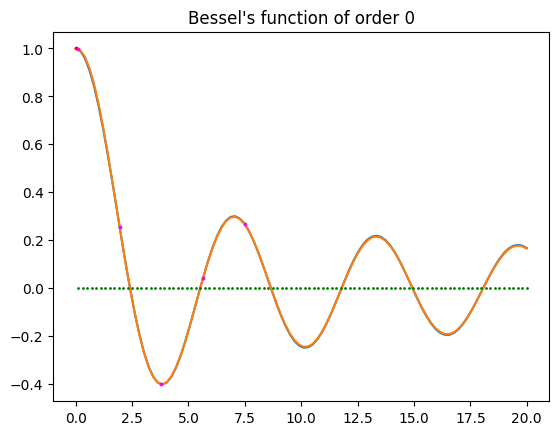

In [6]:

plt.plot(x_real, y_real)
plt.plot(x_real, model(x_real))
plt.scatter(x_phys, [0] * x_phys.shape[0], color="green", s=1, zorder=3)
plt.scatter(x_bound, j0(x_bound), color="red", s=3, zorder=3)
plt.scatter(x_inn, j0(x_inn), color="magenta", s=3, zorder=3)
plt.title("Bessel's function of order 0")
plt.show()